# *PyWAsP* tutorial 5 <br><br> Importing objects from a WAsP workspace (WWH file) 

This tutorial covers a `pywasp` feature that lets users import objects from a WAsP workspace hierarchy (`.wwh`) file, and perform `pywasp` calculations with them. 
We will use the 'Parque Ficticio' workspace, which is also provided with the (Windows) WAsP GUI since version 11. 

Based on the observed wind climate and its location given in this WWH, we will calculate site effects and predicted wind climates over a uniform grid, as was done in the first tutorial on resource grids.

After importing the necessary libraries, let's read the `wwh` file and list its contents:

In [1]:
import warnings
warnings.filterwarnings('ignore')  # We will ignore warnings to avoid cluttering the notebook

import windkit as wk
import pywasp as pw
import numpy as np

In [2]:
wwh = wk.Workspace.read_wwh('./data/import/ParqueFicticio.wwh')
wwh

 Object ID       Object description                               Object CRS
         3               Vector map {'elevation': 32619, 'roughness': 32619}
         6       Turbine site group                                       {}
        17 Generalised wind climate                                       {}
        19    Observed wind climate                                       {}
        22               Vector map {'elevation': 32619, 'roughness': 32619}

The listed objects can be imported as `pywasp` `xarray` datasets, by calling the corresponding `wwh.get_` method and supplying the desired object `id` (possibly also with some additional parameters, depending on the object type). 
The first thing to notice is that we have two ID's assigned to vector map objects. 
These two vector maps are identical, coming from a typical workspace where the vector map contains both roughness-change contours and elevation contours.  
Each Object ID number tells `WAsP` to read the vector map in a specific way: one as an `elevation` map, and the other as a `roughness` map. 
As you will see later in this tutorial, we do this a bit differently in `pywasp`, compared to using WAsP's GUI. 

We now need to import the various objects listed.  
As an exercise, we'll also export them as `NetCDF` files, which are commonly used in meteorological applications and large wind atlases.

### Importing an OWC from the workspace
Let's start with the `Observed wind climate`. To get the OWC, we call the `wwh` method `get_owc()` and provide the id of this object:

In [3]:
bwc = wwh.get_owc(19)
print(bwc)

<xarray.Dataset>
Dimensions:       (point: 1, sector: 12, wsbin: 27)
Coordinates:
    height        (point) float64 42.25
    south_north   (point) float64 6.513e+06
    west_east     (point) float64 2.622e+05
    crs           int8 0
    wsceil        (wsbin) float64 1.0 2.0 3.0 4.0 5.0 ... 24.0 25.0 26.0 27.0
    wsfloor       (wsbin) float64 0.0 1.0 2.0 3.0 4.0 ... 23.0 24.0 25.0 26.0
  * wsbin         (wsbin) float64 0.5 1.5 2.5 3.5 4.5 ... 23.5 24.5 25.5 26.5
    sector_ceil   (sector) float64 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
    sector_floor  (sector) float64 345.0 15.0 45.0 75.0 ... 255.0 285.0 315.0
  * sector        (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Dimensions without coordinates: point
Data variables:
    wdfreq        (sector, point) float64 0.0706 0.0318 ... 0.1284 0.0883
    wsfreq        (wsbin, sector, point) float64 0.02467 0.01616 ... 0.0002156
Attributes:
    Conventions:      CF-1.8
    history:          Fri Jan 13 14:50:13 2023: cf.

In [4]:
bwc.to_netcdf('./data/export/bwc.nc')

### Importing a GWC from the workspace
In a similar fashion to the OWC, we import the `Generalised wind climate`, using the `wwh.get_gwc` method; we likewise export it to `NetCDF` file:

In [5]:
gwc = wwh.get_gwc(17)
print(gwc)

gwc.to_netcdf('./data/export/gwc.nc')

<xarray.Dataset>
Dimensions:        (point: 1, gen_height: 5, gen_roughness: 5, sector: 12)
Coordinates:
    height         (point) float64 42.25
    south_north    (point) float64 6.513e+06
    west_east      (point) float64 2.622e+05
    crs            int8 0
  * gen_height     (gen_height) float64 10.0 25.0 50.0 100.0 200.0
  * gen_roughness  (gen_roughness) float64 0.0 0.03 0.1 0.4 1.5
    sector_ceil    (sector) float64 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
    sector_floor   (sector) float64 345.0 15.0 45.0 75.0 ... 255.0 285.0 315.0
  * sector         (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Dimensions without coordinates: point
Data variables:
    A              (gen_height, gen_roughness, sector, point) float64 4.113 ....
    k              (gen_height, gen_roughness, sector, point) float64 1.799 ....
    wdfreq         (gen_height, gen_roughness, sector, point) float64 0.04582...
Attributes:
    wasp_header:  Cerro


### Importing vector maps from the WAsP workspace
Now let's load the maps.  To do this we call the method `wwh.get_vectormap`, which requires following parameters:
 - `id`: id of the vector map object in the wwh list (integer)
 - `srs`: EPSG code of the map
 - `map_type`: feature type to extract from mapfile, it can be 'elevation' or 'roughness'

In our example the vector map header has following information: "UTM-Proj.-S.hemisph. Zone 19 (WGS 1984)". 
This corresponds to an [EPSG code of 32719](https://epsg.io/32719). 
However, the output of `pw.io.Workspace.read_wwh` shows code 32619, because the header should say "...Zone19**S**...". 

> **_maps note_**: One may need to examine map headers and ensure one knows the projection/datum (coordinates) of the map, or for locations within observed wind climate files.  See [the EPSG site](https://epsg.io) to check coordinate systems.  Sometimes one must look at map data and repeat reading it in, to transform coordinates properly. 

We will extract both the elevation and roughness maps; we can use either `ID` (3 or 22). 
We will then bundle these two maps together using `wasp.TopographyMap`, which is needed for the various flow-perturbation calculations.

In [6]:
elev_map = wwh.get_vector_map(22, "elevation", 32719)
rough_map, lut = wwh.get_vector_map(22, "roughness", 32719)


topo_map = pw.wasp.TopographyMap(elev_map, rough_map, lut)

If we closely inspect the OWC data (look at `bwc.crs` and click on check attributes or look at `bwc.crs.crs_wkt`), we notice that the provided geospatial location of the mast in this dataset is in coordinates following the [EPSG:4326](https://epsg.io/4326) projection (with south_north=latitude and west_east=longitude, i.e., in degrees not m). 

However, as our terrain and rougness data are in UTM Zone 19S ([EPSG:32719](https://epsg.io/32719)) we will convert and update the mast coordinates. Once the coordiantes are converted we will store them in in variables `loc_x` and `loc_y` for later use.

In [7]:
bwc = wk.spatial.reproject(bwc, 32719)
loc_y = bwc.south_north
loc_x = bwc.west_east

## (re-)calculating predicted wind climates 
#### creating a grid of locations
Let's first create uniform grid, with resolution of 100 m in `west_east` and `north_south` coordinate. The grid will be positioned 200 m above the ground level. We use `pw.create_dataset` to perform this.

In [8]:
height = 200
x_res = 100
y_res = 100

output_locs = wk.create_dataset(
    np.arange(262878, 265078 + x_res, x_res),
    np.arange(6504214, 6507414 + y_res, y_res),
    np.array([height]),
    32719
)

#### calculating predicted wind climates over the grid
Let's now calculate predicted wind climate,  site effects, and meteorological variables, using the `pw.wasp.downscale routine`. We will then export this to a `NetCDF` file:

In [9]:
conf = pw.wasp.Config()
pwc = pw.wasp.downscale(gwc, topo_map, output_locs, conf, genwc_interp='nearest', return_site_factors=True)
print(pwc)

<xarray.Dataset>
Dimensions:              (sector: 12, south_north: 33, west_east: 23, height: 1)
Coordinates:
  * sector               (sector) float64 0.0 30.0 60.0 ... 270.0 300.0 330.0
    crs                  int8 0
    sector_ceil          (sector) float64 15.0 45.0 75.0 ... 285.0 315.0 345.0
    sector_floor         (sector) float64 345.0 15.0 45.0 ... 255.0 285.0 315.0
  * height               (height) int64 200
  * south_north          (south_north) int64 6504214 6504314 ... 6507314 6507414
  * west_east            (west_east) int64 262878 262978 ... 264978 265078
Data variables: (12/20)
    z0meso               (sector, south_north, west_east) float32 0.1 ... 0.0...
    slfmeso              (sector, south_north, west_east) float32 1.0 ... 0.9768
    displ                (sector, south_north, west_east) float32 0.0 ... 0.0
    user_def_speedups    (sector, height, south_north, west_east) float32 1.0...
    orographic_speedups  (sector, height, south_north, west_east) float32 0

In [10]:
pwc.to_netcdf('./data/export/results_'+str(height)+'_m.nc')

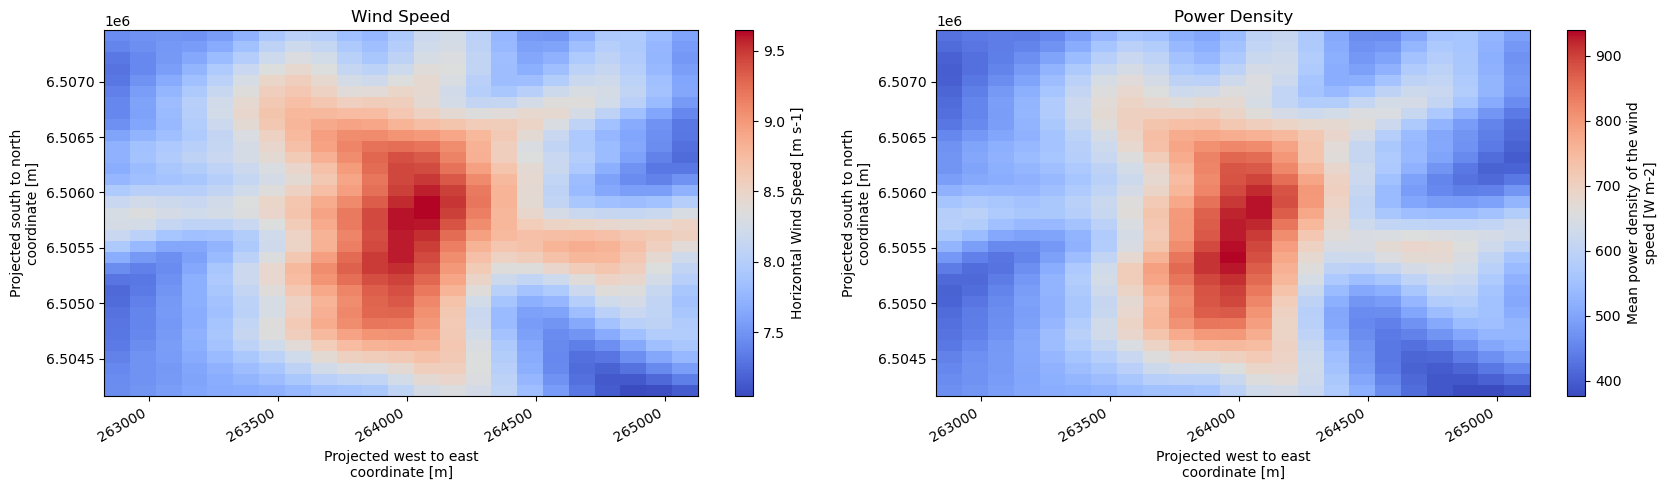

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
ax1, ax2 = axes.flat
variables = ['wspd', 'power_density']
for var, ax in zip(variables, axes.flat):
    pwc[var].isel(height=0).plot(ax=ax, cmap='coolwarm')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax1.set_title("Wind Speed")
ax2.set_title("Power Density");
fig.tight_layout()   

#### Get turbine hub positions (_x,y,z_) from the workspace, and predict wind climates for them
Finally let's extract the positions of the wind turbines, and their hub height. 
To do this we use the `wwh` method `get_turbines()`. 
This method requires `id` and `srs` as inputs, and generates an `xarray` dataset containing the positions of wind turbines:

In [12]:
wtg_pos = wwh.get_turbines(6, 32719)
print(wtg_pos)

<xarray.Dataset>
Dimensions:      (point: 8)
Coordinates:
    height       (point) float64 70.0 70.0 70.0 70.0 70.0 70.0 70.0 70.0
    south_north  (point) float64 6.505e+06 6.505e+06 ... 6.506e+06 6.507e+06
    west_east    (point) float64 2.639e+05 2.64e+05 ... 2.639e+05 2.637e+05
    crs          int8 0
Dimensions without coordinates: point
Data variables:
    output       (point) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.8
    history:      2023-01-13T13:50:18:\twindkit==0.5.2.dev17+gf46f628\t      ...


Now we can calculate and see what the power densities look like at the turbine sites:

In [13]:
pwc_wtgs = pw.wasp.downscale(gwc, topo_map, wtg_pos, conf, genwc_interp='nearest', return_site_factors=True)

In [14]:
print(pwc_wtgs.power_density.values)

[582.5069  650.9849  675.2678  618.57355 667.49414 632.60315 523.6245
 432.3443 ]


Quick question:  why do these power densities seem much lower than the ones in the plot further above? <br>
(hint: what is different between `output_locs` and `wtg_pos`?)